In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torch_geometric.loader import DataLoader
from data_utils import *
from tqdm import tqdm
import pandas as pd

import networkx as nx
import torch_geometric.utils as pyg_utils

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

from data_utils import *
from graph_vae.vae import GraphVAE

In [75]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
include_hydrogen = False

properties = ["homo", "lumo", "r2"]

prop_norm_df = create_or_load_property_norm_df()
    
# create dataset and dataloaders
dataset = create_qm9_dataset(
    device=device, 
    include_hydrogen=False, 
    refresh_data_cache=False,
    properties=properties,
    prop_norm_df=prop_norm_df
)

_, val_dataset, _ = create_qm9_data_split(dataset=dataset)

mol_indices = [8, 190, 59, 101]
val_dataset = val_dataset[mol_indices]

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

# old: ./checkpoints/graph_vae_20240416_221922.pt
model = GraphVAE.from_pretrained(checkpoint_path="./checkpoints/graph_vae_20240502_125508.pt").to(device)
model.eval()
# old: ./checkpoints/graph_vae_20240416_225315.pt
model_split = GraphVAE.from_pretrained(checkpoint_path="./checkpoints/graph_vae_20240503_021631.pt").to(device)
model_split.eval()
print()

In [71]:
full_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)
dataset_smiles_with_prop = dict()
for batch in tqdm(full_loader, desc="Converting dataset graphs to SMILES"):
    for sample_index in range(len(batch)):
        sample = batch[sample_index]
        mol = graph_to_mol(data=sample, includes_h=include_hydrogen, validate=False)
        dataset_smiles_with_prop[Chem.MolToSmiles(mol)] = sample.y

Converting dataset graphs to SMILES:   0%|          | 0/501 [00:00<?, ?it/s]

Converting dataset graphs to SMILES: 100%|██████████| 501/501 [03:17<00:00,  2.54it/s]


# Optimize properties with MLE

In [197]:
def optimize_z_for_properties(model, z, properties):
    z.requires_grad_(True)
    optimizer = torch.optim.LBFGS([z], lr=1e-1)

    def closure():
        optimizer.zero_grad()
        y_mu, y_sigma = model.predict_properties(z)
        # var = y_sigma * y_sigma
        loss = ((properties - y_mu) ** 2) + (z ** 2).sum() * 1e-8

        loss = loss.mean()
        loss.backward()
        return loss
    
    for i in tqdm(range(100)):
        loss = optimizer.step(closure)

    print(f"Property optimization loss = {loss}")
    return z.detach()

In [125]:
import pandas as pd

z_list = []
props_list = []
for batch in tqdm(loader):
    z = model.encode(batch).detach().cpu()
    z = model.z_to_property_z(z)
    z_list.append(z)
    props_list.append(batch.y)

z_pca = torch.concat(z_list)
props = torch.concat(props_list)
prop_df = pd.DataFrame(props.cpu(), columns=model.properties).reset_index()

  0%|          | 0/501 [00:00<?, ?it/s]

100%|██████████| 501/501 [00:39<00:00, 12.66it/s]


100%|██████████| 100/100 [00:01<00:00, 60.46it/s]


Property optimization loss = 2.4527389541617595e-06


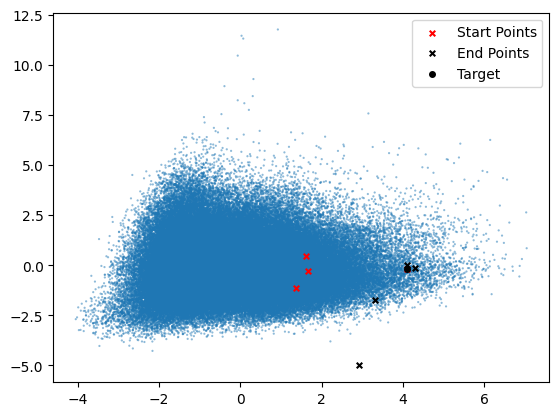

In [202]:
prop_opt = "lumo"

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler


# do pca and normalize
z = z_pca
pca_transform = PCA(n_components=2)
pca_transform = pca_transform.fit(z)
Z_pca = pca_transform.transform(z)
#Z_pca = MinMaxScaler().fit_transform(Z_pca)

df = pd.DataFrame(np.transpose((Z_pca[:,0],Z_pca[:,1])))
df.columns = ['x','y']
#sdf[prop_opt] = ((prop_df[model.properties] - target_properties[0]))[prop_opt]

scatter = plt.scatter(x=df['x'], y=df['y'], marker='.',
            s=10, alpha=0.5, edgecolors='none')

target_index = 3

batch = next(iter(val_loader))
z_start_gpu = model.encode_mean(batch).detach()
z_start = z_start_gpu.cpu().numpy()
Z_pca = pca_transform.transform(z_start)
df = pd.DataFrame(np.transpose((Z_pca[:,0],Z_pca[:,1])))
df.columns = ['x','y']

scatter = plt.scatter(x=df['x'], y=df['y'], color="red",
            marker='x', s=16, alpha=1.0, label="Start Points")

end_z = optimize_z_for_properties(
        model=model,
        z=z_start_gpu,
        properties=batch[target_index].y
    )
z_end = end_z.cpu().detach().numpy()
Z_pca = pca_transform.transform(z_end)
df = pd.DataFrame(np.transpose((Z_pca[:,0],Z_pca[:,1])))
df.columns = ['x','y']

scatter = plt.scatter(x=df['x'], y=df['y'], color="black",
            marker='x', s=16, alpha=1.0, label="End Points")

Z_pca = pca_transform.transform(z_start[target_index:target_index+1])
df = pd.DataFrame(np.transpose((Z_pca[:,0],Z_pca[:,1])))
df.columns = ['x','y']

scatter = plt.scatter(x=df['x'], y=df['y'], color="black",
            marker='o', s=16, alpha=1.0, label="Target")

#plt.colorbar(scatter, label=prop_opt)
plt.legend()
plt.show()

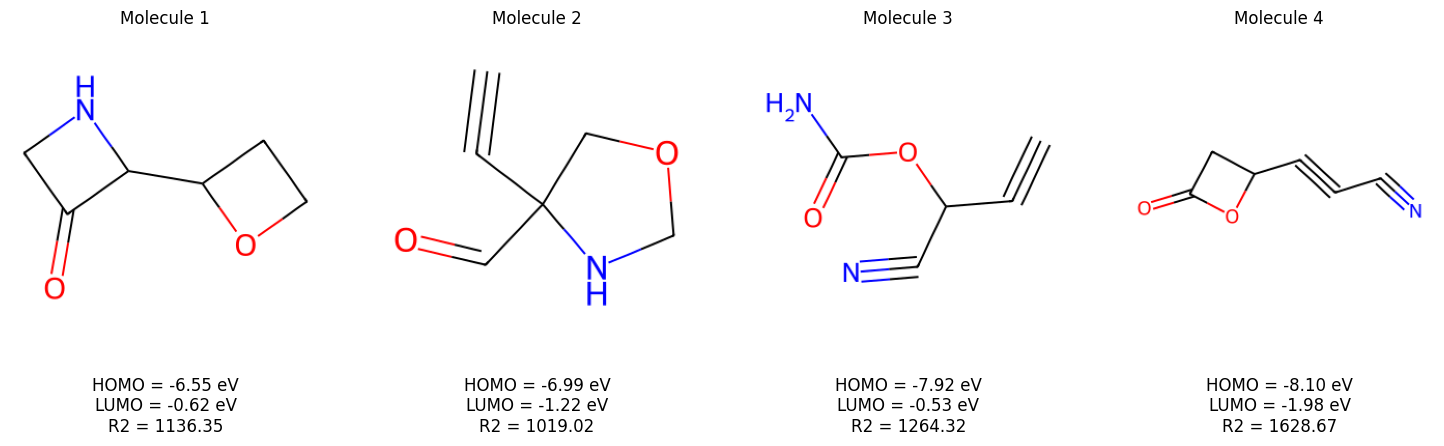

Original z distances to target mol 1: [0.       7.892852 8.449182 6.873455]


100%|██████████| 100/100 [00:01<00:00, 73.42it/s]


Property optimization loss = 1.2335257224549423e-06
Optimized z distances to target mol 1: [0.        7.8164983 7.8981743 4.954933 ]


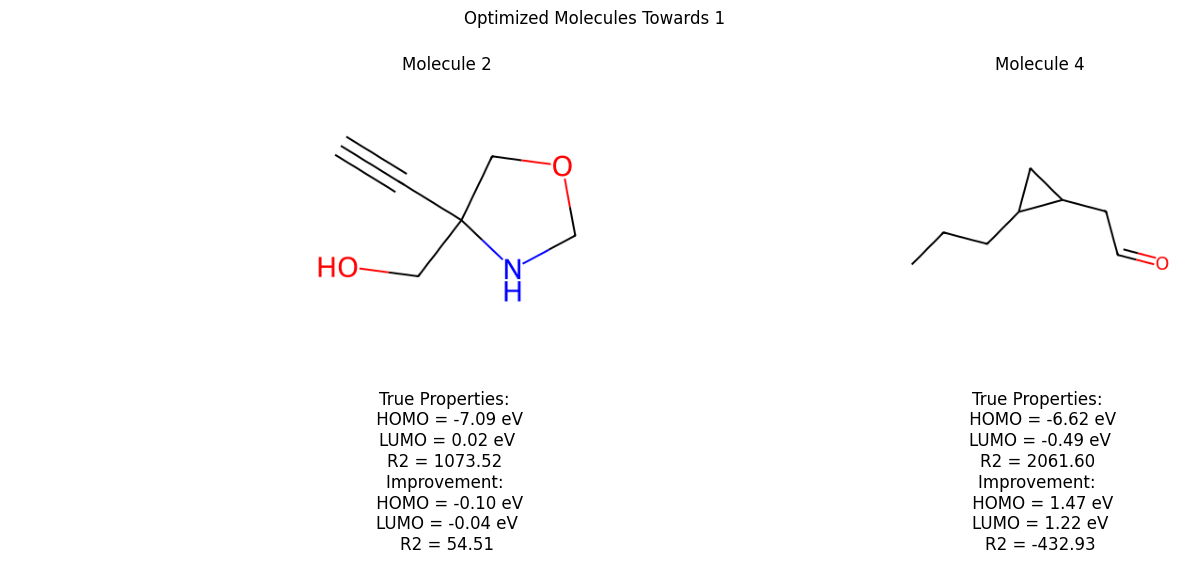

Original z distances to target mol 2: [7.892852 0.       8.812906 9.709894]


100%|██████████| 100/100 [00:01<00:00, 68.21it/s] 


Property optimization loss = 1.3830058378516696e-06
Optimized z distances to target mol 2: [7.7773123 0.        8.337846  8.622655 ]


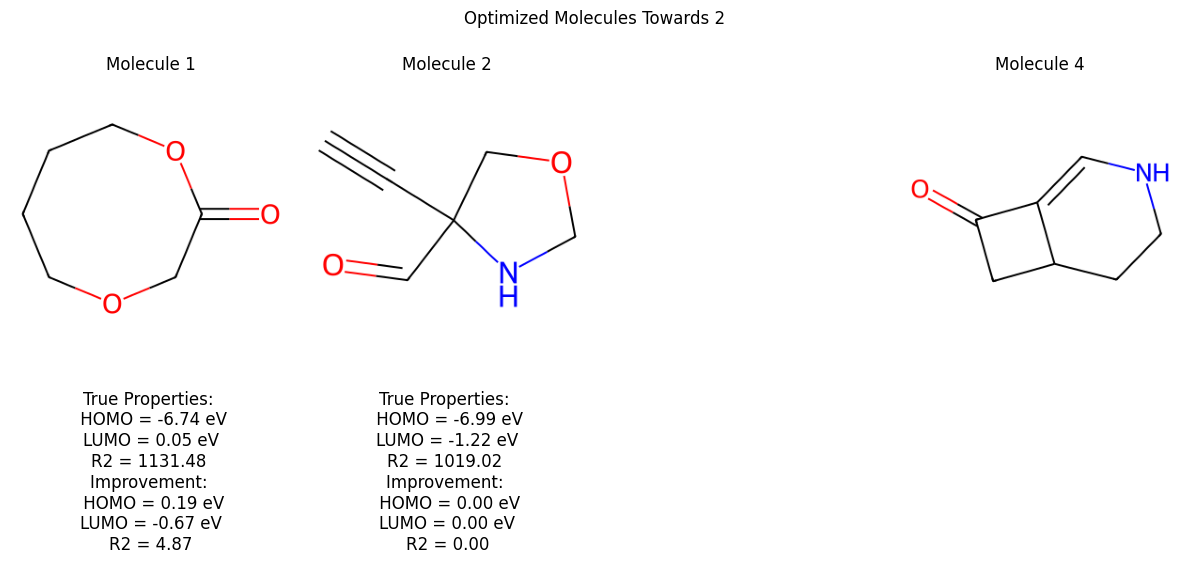

Original z distances to target mol 3: [8.4491825 8.812906  0.        7.8076878]


100%|██████████| 100/100 [00:01<00:00, 68.63it/s]


Property optimization loss = 1.7319564449280733e-06
Optimized z distances to target mol 3: [7.063008 8.279641 0.       7.337535]


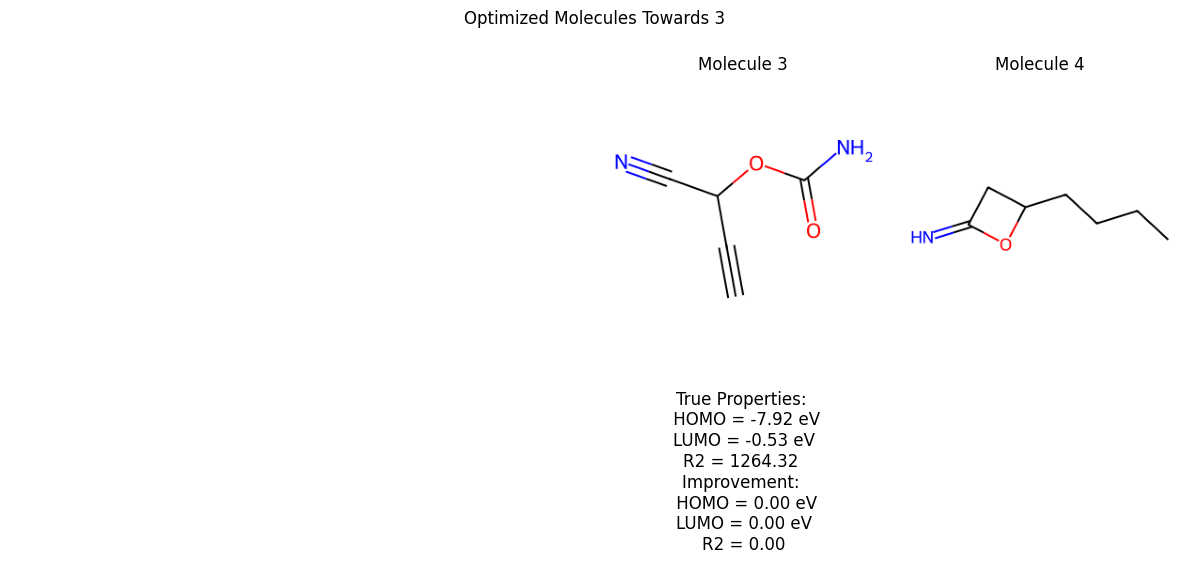

Original z distances to target mol 4: [6.873455  9.709894  7.8076878 0.       ]


100%|██████████| 100/100 [00:01<00:00, 63.83it/s]


Property optimization loss = 2.4527282675990136e-06
Optimized z distances to target mol 4: [ 5.433343  10.225656   7.4782505  0.       ]


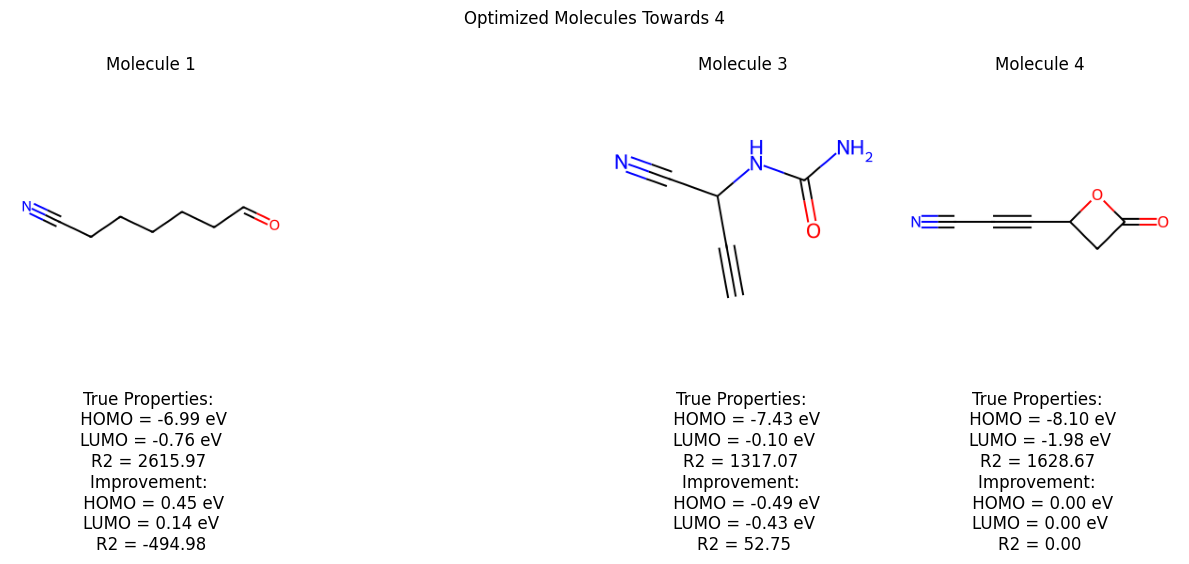

Improvement Mean 
 HOMO: 0.30
 LUMO: 0.04
 R2 -163.16
Improvement Std 
 HOMO: 0.74
 LUMO: 0.73
 R2 276.18
Improvement Mean 
 HOMO: 1.26
 LUMO: 1.10
 R2 1.25
Improvement Median 
 HOMO: 0.71
 LUMO: 1.06
 R2 0.96
Improvement Std 
 HOMO: 1.45
 LUMO: 0.73
 R2 0.66


In [203]:
###################################################
# plot molecules with target properties
###################################################
fig, axs = plt.subplots(1, len(val_dataset), figsize=(15, 4))
for target_mol_index in range(len(val_dataset)):
    src_mol_graph = val_dataset[target_mol_index]
    src_mol = graph_to_mol(src_mol_graph, includes_h=False, validate=False)
    src_mol_img = mol_to_image_tensor(src_mol).transpose(1, 3).transpose(1, 2)

    # Display the molecule image
    ax = axs[target_mol_index]
    ax.imshow(src_mol_img[0])
    ax.set_title(f"Molecule {target_mol_index + 1}")
    ax.axis("off")

    # Retrieve and normalize properties
    properties = model.denormalize_properties(src_mol_graph.y.to(device))[0]
    homo = properties[0]
    lumo = properties[1]
    r2 = properties[2]

    # Display properties as text on the plot
    ax.text(src_mol_img.shape[2]//2, src_mol_img.shape[2] + 32,
            f"HOMO = {homo:.2f} eV\nLUMO = {lumo:.2f} eV\nR2 = {r2:.2f}",
            ha='center', va='top', fontsize=12)

plt.tight_layout()
plt.show()

delta_delta_list = []
relative_delta_list = []
for target_mol_index in range(len(val_dataset)):

    ###################################################
    # optimize mols towards target and print distances
    ###################################################
    batch = next(iter(val_loader))
    target_z = model.encode_mean(batch).detach()

    print(f"Original z distances to target mol {target_mol_index + 1}: {torch.cdist(target_z, target_z)[target_mol_index].detach().cpu().numpy()}")
    z = optimize_z_for_properties(
        model=model,
        z=target_z,
        properties=batch[target_mol_index].y
    )
    print(f"Optimized z distances to target mol {target_mol_index + 1}: {torch.cdist(z, target_z)[target_mol_index].detach().cpu().numpy()}")

    target_properties = model.denormalize_properties(batch[target_mol_index].y)
    source_properties = model.denormalize_properties(batch.y)
    original_delta = (target_properties - source_properties).abs()
    
    ###################################################
    # plot optimized mols
    ###################################################
    x = model.decode(z)

    num_mols = len(mol_indices)
    cols = num_mols

    fig, axs = plt.subplots(1, cols, figsize=(cols * 3, 5))  # Adjust size as needed
    fig.suptitle(f"Optimized Molecules Towards {target_mol_index + 1}")
    axs = axs.flatten()  # Flatten to ease the handling of the axis array

    for i in range(num_mols):
        sample_matrices = (x[0][i:i+1], x[1][i:i+1], x[2][i:i+1])

        sample_graph = model.output_to_graph(x=sample_matrices, stochastic=False)

        # Check if the generated graph is connected
        if not nx.is_connected(pyg_utils.to_networkx(sample_graph, to_undirected=True)):
            continue

        try:
            mol = graph_to_mol(data=sample_graph, includes_h=include_hydrogen, validate=True)
        except Exception as e:
            # Molecule is invalid; try to decode again
            continue

        # Molecule is valid
        if mol:
            img = Draw.MolToImage(mol)
            axs[i].imshow(img)
            axs[i].set_title(f"Molecule {i + 1}")
            smiles = Chem.MolToSmiles(mol)
            if smiles in dataset_smiles_with_prop:
                norm_properties = dataset_smiles_with_prop[smiles]
                properties = model.denormalize_properties(norm_properties.to(device))[0]
                homo = properties[0]
                lumo = properties[1]
                r2 = properties[2]
                text = f"True Properties: \n HOMO = {homo:.2f} eV\nLUMO = {lumo:.2f} eV\nR2 = {r2:.2f} \n"

                new_delta = (target_properties - properties).abs()
                # compute the difference between the property distance in the original molecule to the target compared to the distance of the true properties of the optimized molecule
                delta_delta = (original_delta[i] - new_delta)[0]
                text += f"Improvement: \n HOMO = {delta_delta[0]:.2f} eV\nLUMO = {delta_delta[1]:.2f} eV\nR2 = {delta_delta[2]:.2f}"
                relative_delta = ((new_delta) / (original_delta[i]))[0]
                if i != target_mol_index:
                    delta_delta_list.append(delta_delta)
                    relative_delta_list.append(relative_delta)

                axs[i].text(src_mol_img.shape[2]//2, src_mol_img.shape[2] + 32, 
                        text,
                        ha='center', va="top", fontsize=12)

    for i in range(len(val_dataset)):
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()

delta_deltas = torch.stack(delta_delta_list, dim=0)
mean_property_improvement = delta_deltas.mean(0)
std_property_improvement = delta_deltas.std(0)
print(f"Improvement Mean \n HOMO: {mean_property_improvement[0]:.2f}\n LUMO: {mean_property_improvement[1]:.2f}\n R2 {mean_property_improvement[2]:.2f}")
print(f"Improvement Std \n HOMO: {std_property_improvement[0]:.2f}\n LUMO: {std_property_improvement[1]:.2f}\n R2 {std_property_improvement[2]:.2f}")

relative_deltas = torch.stack(relative_delta_list, dim=0)
mean_property_improvement = relative_deltas.mean(0)
median_property_improvement = relative_deltas.quantile(q=0.5, dim=0)
std_property_improvement = relative_deltas.std(0)
print(f"Improvement Mean \n HOMO: {mean_property_improvement[0]:.2f}\n LUMO: {mean_property_improvement[1]:.2f}\n R2 {mean_property_improvement[2]:.2f}")
print(f"Improvement Median \n HOMO: {median_property_improvement[0]:.2f}\n LUMO: {median_property_improvement[1]:.2f}\n R2 {median_property_improvement[2]:.2f}")
print(f"Improvement Std \n HOMO: {std_property_improvement[0]:.2f}\n LUMO: {std_property_improvement[1]:.2f}\n R2 {std_property_improvement[2]:.2f}")

# Sample Posterior Subset

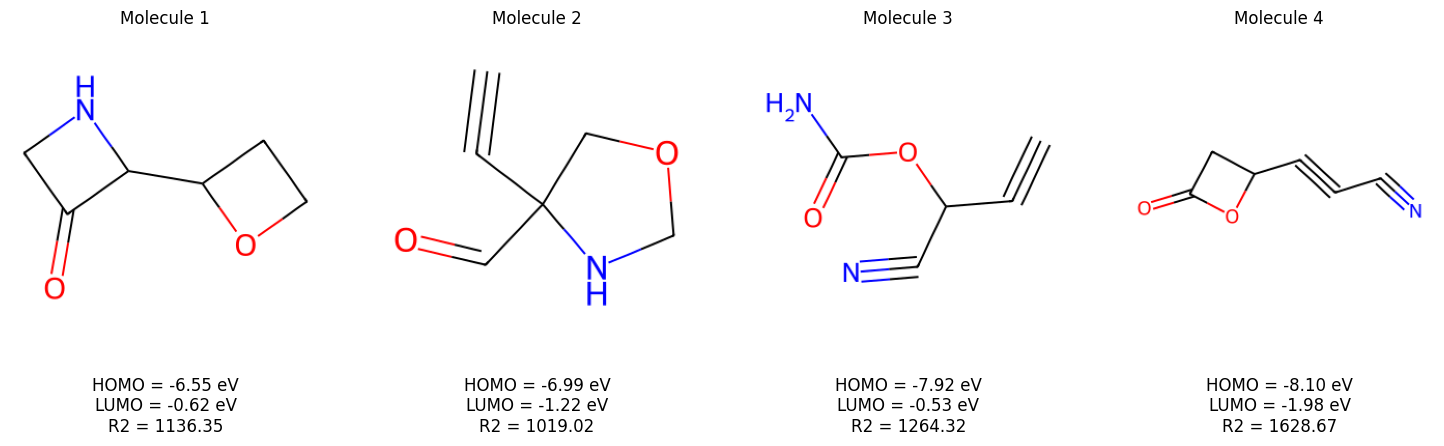

Original z distances to target mol 2: [3.52895  0.       4.483636 4.926478]


100%|██████████| 100/100 [00:01<00:00, 79.31it/s]


Property optimization loss = 1.1998542959190672e-06
Optimized z distances to target mol 2: [3.2023506 0.        4.079067  3.4909096]


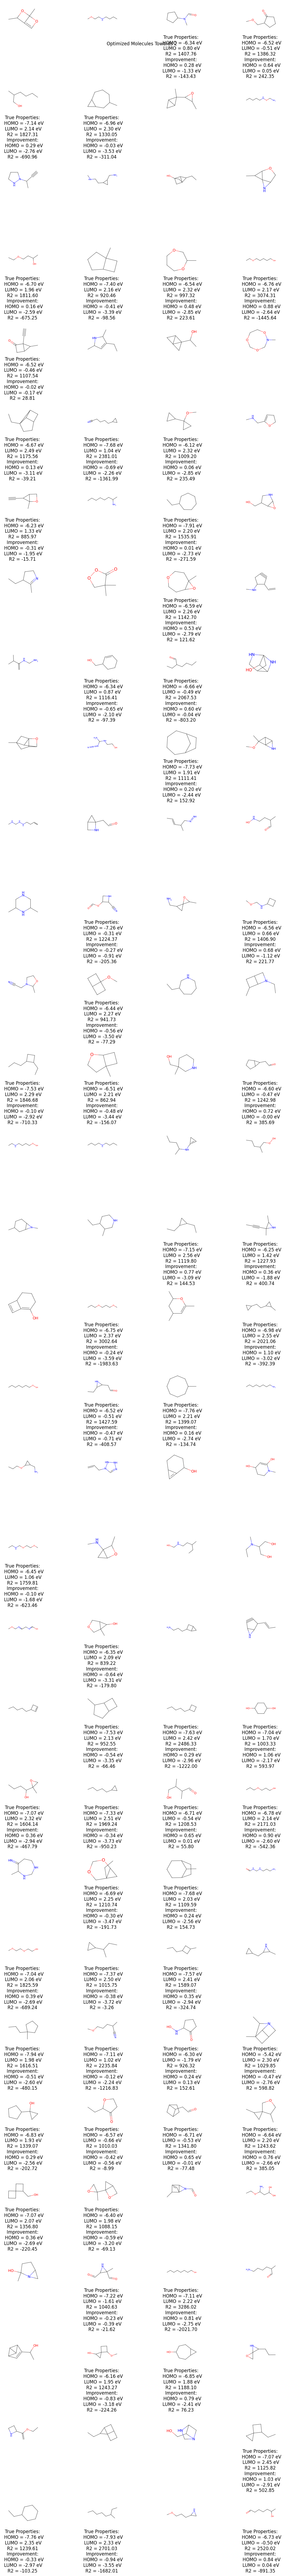

tensor([0.4277, 4.7645, 1.4417], device='cuda:0')
tensor([0.6026, 4.1111, 2.3472], device='cuda:0')


In [205]:
###################################################
# plot molecules with target properties
###################################################
fig, axs = plt.subplots(1, len(val_dataset), figsize=(15, 4))
for target_mol_index in range(len(val_dataset)):
    src_mol_graph = val_dataset[target_mol_index]
    src_mol = graph_to_mol(src_mol_graph, includes_h=False, validate=False)
    src_mol_img = mol_to_image_tensor(src_mol).transpose(1, 3).transpose(1, 2)

    # Display the molecule image
    ax = axs[target_mol_index]
    ax.imshow(src_mol_img[0])
    ax.set_title(f"Molecule {target_mol_index + 1}")
    ax.axis("off")

    # Retrieve and normalize properties
    properties = model.denormalize_properties(src_mol_graph.y.to(device))[0]
    homo = properties[0]
    lumo = properties[1]
    r2 = properties[2]

    # Display properties as text on the plot
    ax.text(src_mol_img.shape[2]//2, src_mol_img.shape[2] + 32,
            f"HOMO = {homo:.2f} eV\nLUMO = {lumo:.2f} eV\nR2 = {r2:.2f}",
            ha='center', va='top', fontsize=12)

plt.tight_layout()
plt.show()

relative_delta_list = []
for target_mol_index in range(len(val_dataset)):
    if target_mol_index != 1:
        continue

    ###################################################
    # optimize mols towards target and print distances
    ###################################################
    batch = next(iter(val_loader))
    target_z = model_split.encode_mean(batch).detach()
    target_z_prop = model_split.z_to_property_z(target_z)

    print(f"Original z distances to target mol {target_mol_index + 1}: {torch.cdist(target_z_prop, target_z_prop)[target_mol_index].detach().cpu().numpy()}")
    z = optimize_z_for_properties(
        model=model_split,
        z=target_z,
        properties=batch[target_mol_index].y
    )
    z = target_z
    z_prop = model_split.z_to_property_z(z)
    print(f"Optimized z distances to target mol {target_mol_index + 1}: {torch.cdist(z_prop, target_z_prop)[target_mol_index].detach().cpu().numpy()}")

    target_properties = model.denormalize_properties(batch[target_mol_index].y)
    source_properties = model.denormalize_properties(batch.y)
    original_delta = (target_properties - source_properties).abs()

    ###################################################
    # plot optimized mols
    ###################################################
    random_sample_count = 32
    num_mols = len(mol_indices)
    next_image_index = [0] * num_mols
    cols = num_mols
    fig, axs = plt.subplots(random_sample_count, cols, figsize=(cols * 3, 3 * random_sample_count))  # Adjust size as needed
    fig.suptitle(f"Optimized Molecules Towards {target_mol_index + 1}")

    while any([index < random_sample_count for index in next_image_index]):
    #for random_sample_index in range(random_sample_count):
        random_part = torch.randn(len(val_dataset), 112, device=device)  # 128 - 16 = 112
        
        z = torch.cat((z_prop, random_part), dim=1)
        x = model.decode(z)

        for i in range(num_mols):
            sample_matrices = (x[0][i:i+1], x[1][i:i+1], x[2][i:i+1])

            sample_graph = model_split.output_to_graph(x=sample_matrices, stochastic=False)

            # Check if the generated graph is connected
            if not nx.is_connected(pyg_utils.to_networkx(sample_graph, to_undirected=True)):
                continue

            try:
                mol = graph_to_mol(data=sample_graph, includes_h=include_hydrogen, validate=True)
            except Exception as e:
                # Molecule is invalid; try to decode again
                continue

            # Molecule is valid
            if mol:
                img = Draw.MolToImage(mol)
                image_index = next_image_index[i]
                if image_index >= random_sample_count:
                    continue
                
                next_image_index[i] += 1
                axs[image_index][i].imshow(img)

                smiles = Chem.MolToSmiles(mol)
                text = ""
                if smiles in dataset_smiles_with_prop:
                    norm_properties = dataset_smiles_with_prop[smiles]
                    properties = model_split.denormalize_properties(norm_properties.to(device))[0]
                    homo = properties[0]
                    lumo = properties[1]
                    r2 = properties[2]
                    text += f"True Properties: \n HOMO = {homo:.2f} eV\nLUMO = {lumo:.2f} eV\nR2 = {r2:.2f} \n"
                
                    new_delta = (target_properties - properties).abs()
                    # compute the difference between the property distance in the original molecule to the target compared to the distance of the true properties of the optimized molecule
                    delta_delta = (original_delta[i] - new_delta)[0]
                    text += f"Improvement: \n HOMO = {delta_delta[0]:.2f} eV\nLUMO = {delta_delta[1]:.2f} eV\nR2 = {delta_delta[2]:.2f} "

                    new_delta = (target_properties - properties).abs()
                    relative_delta = ((new_delta) / (original_delta[i]))[0]
                    if i != target_mol_index:
                        relative_delta_list.append(relative_delta)

                axs[image_index][i].text(src_mol_img.shape[2]//2, src_mol_img.shape[2] + 0, 
                        text,
                        ha='center', va="top", fontsize=12)


    for i in range(len(axs)):
        for j in range(len(axs[i])):
            axs[i][j].axis("off")

    plt.tight_layout()
    plt.show()


relative_deltas = torch.stack(relative_delta_list, dim=0)
#mean_property_improvement = relative_deltas.mean(0)
median_property_improvement = relative_deltas.quantile(q=0.5, dim=0)
print(median_property_improvement)
print(relative_deltas.mean(0))